<a href="https://colab.research.google.com/github/Rahmaditadita/PBO-D/blob/master/project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import data & Library

In [24]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

path = kagglehub.dataset_download("emmarex/plantdisease")
print("Path ke dataset files:", path)

base_dir = os.path.join(path, "PlantVillage")

if not os.path.exists(base_dir):
    print("Folder 'PlantVillage' tidak ditemukan.")
    print("Cek isi direktori utama:")
    print(os.listdir(path))
else:
    print("Folder 'PlantVillage' ditemukan!")
    print("Isi folder utama:")
    print(os.listdir(base_dir))


Using Colab cache for faster access to the 'plantdisease' dataset.
Path ke dataset files: /kaggle/input/plantdisease
Folder 'PlantVillage' ditemukan!
Isi folder utama:
['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


Preprocessing Data

In [27]:
potato_classes = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy"
]

potato_dir = "/kaggle/working/Potato_only"

# Hapus folder lama kalau ada
if os.path.exists(potato_dir):
    shutil.rmtree(potato_dir)
os.makedirs(potato_dir, exist_ok=True)

# Copy folder kelas dari base_dir
for cls in potato_classes:
    src = os.path.join(base_dir, cls)
    dst = os.path.join(potato_dir, cls)
    shutil.copytree(src, dst)

train_dir = os.path.join(potato_dir, "train")
val_dir = os.path.join(potato_dir, "val")
test_dir = os.path.join(potato_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_split, val_split, test_split = 0.7, 0.2, 0.1

for cls in potato_classes:
    cls_src = os.path.join(potato_dir, cls)
    files = os.listdir(cls_src)
    np.random.shuffle(files)

    n = len(files)
    train_end = int(train_split * n)
    val_end = train_end + int(val_split * n)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for folder in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

    # Copy file ke folder train/val/test
    for f in train_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(train_dir, cls))
    for f in val_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(val_dir, cls))
    for f in test_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(test_dir, cls))


In [28]:
import os

for cls in ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]:
    cls_path = os.path.join(test_dir, cls)
    print(cls, ":", len(os.listdir(cls_path)), "images")


Potato___Early_blight : 100 images
Potato___Late_blight : 100 images
Potato___healthy : 16 images


Augmentasi Khusus Potato healthy


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Folder train
classes = ["Potato___Late_blight", "Potato___healthy", "Potato___Early_blight"]
target_images = 800

# Setup augmentasi
datagen_train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    shear_range=0.15,
    fill_mode='nearest'
)

for cls in classes:
    class_path = os.path.join(train_dir, cls)

    # Hapus augmentasi lama
    for f in os.listdir(class_path):
        if f.startswith("aug_"):
            os.remove(os.path.join(class_path, f))

    # File asli
    original_files = [f for f in os.listdir(class_path) if not f.startswith("aug_")]
    current_images = len(original_files)

    i = 0
    while current_images + i < target_images:
        img_name = np.random.choice(original_files)
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        x = np.expand_dims(img_to_array(img), axis=0)

        save_prefix = "aug_" + os.path.splitext(img_name)[0]
        batch_iter = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=save_prefix,
            save_format='jpg'
        )
        next(batch_iter)  # generate 1 gambar
        i += 1

    print(f"Augmentasi {cls} {len(os.listdir(class_path))}")

Augmentasi Potato___Late_blight 800
Augmentasi Potato___healthy 800
Augmentasi Potato___Early_blight 800


In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

# Folder validation
classes = ["Potato___Late_blight", "Potato___healthy", "Potato___Early_blight"]
target_images = 200  # target per kelas

# Setup augmentasi
datagen_val = ImageDataGenerator(rescale=1./255)

for cls in classes:
    class_path = os.path.join(val_dir, cls)

    # Hapus augmentasi lama
    for f in os.listdir(class_path):
        if f.startswith("aug_"):
            os.remove(os.path.join(class_path, f))

    # Ambil file asli
    original_files = [f for f in os.listdir(class_path) if not f.startswith("aug_")]
    current_images = len(original_files)

    if current_images >= target_images:
        print(f"{cls} sudah >= {target_images}, skip augmentasi.")
        continue

    i = 0
    while current_images + i < target_images:
        img_name = np.random.choice(original_files)
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        x = np.expand_dims(img_to_array(img), axis=0)

        save_prefix = "aug_" + os.path.splitext(img_name)[0]
        batch_iter = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=save_prefix,
            save_format='jpg'
        )
        next(batch_iter)  # generate 1 gambar
        i += 1

    print(f"Augmentasi {cls} Total sekarang: {len(os.listdir(class_path))}")


Potato___Late_blight sudah >= 200, skip augmentasi.
Augmentasi Potato___healthy Total sekarang: 200
Potato___Early_blight sudah >= 200, skip augmentasi.


DataGenerator, class weight, dan plot sample

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Total training images: 2400
Total validation images: 600

Distribusi kelas:
{'Potato___Early_blight': 800, 'Potato___Late_blight': 800, 'Potato___healthy': 800}

Class weights:
{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


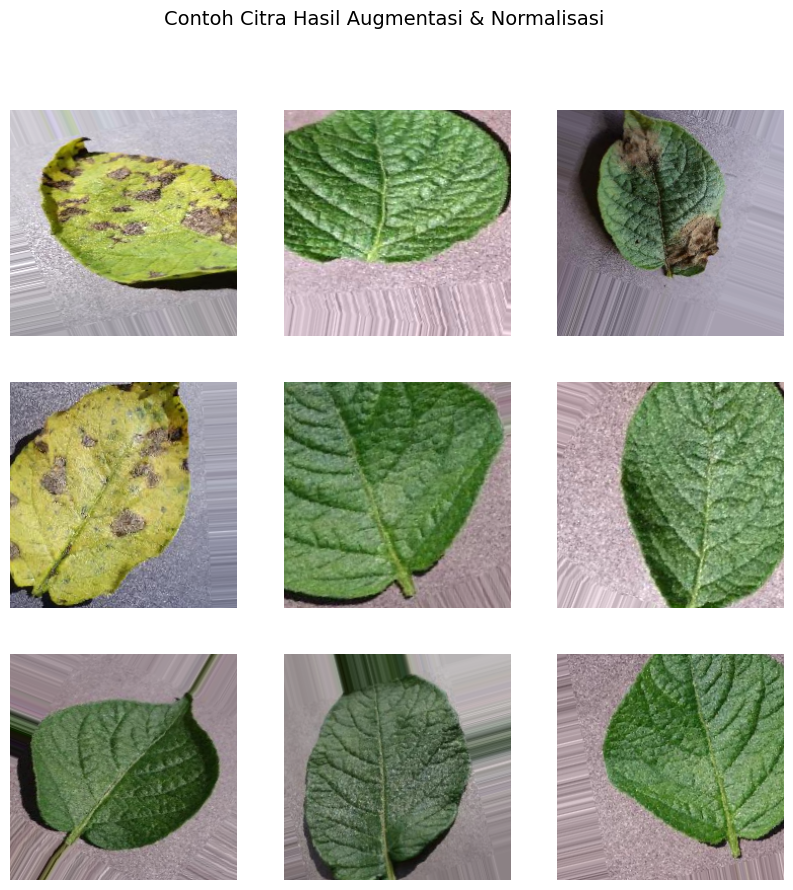

In [58]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,      # <- shear
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Total training images: {train_generator.samples}")
print(f"Total validation images: {val_generator.samples}")

counts = pd.Series(train_generator.classes).value_counts()
labels = list(train_generator.class_indices.keys())
print("\nDistribusi kelas:")
print(dict(zip(labels, counts)))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:")
print(class_weights)

sample_images, _ = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle("Contoh Citra Hasil Augmentasi & Normalisasi", fontsize=14)
plt.show()


In [59]:
import os
from collections import Counter

def count_images_per_class(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return counts

print("=== Jumlah gambar di TRAIN ===")
train_counts = count_images_per_class(train_dir)
for cls, cnt in train_counts.items():
    print(f"{cls}: {cnt}")

print("\n=== Jumlah gambar di VALIDATION ===")
val_counts = count_images_per_class(val_dir)
for cls, cnt in val_counts.items():
    print(f"{cls}: {cnt}")


=== Jumlah gambar di TRAIN ===
Potato___Late_blight: 800
Potato___healthy: 800
Potato___Early_blight: 800

=== Jumlah gambar di VALIDATION ===
Potato___Late_blight: 200
Potato___healthy: 200
Potato___Early_blight: 200


Bangun Model

In [60]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall

# Load base model EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412,326 (16.83 MB)

 Trainable params: 361,987 (1.38 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

Training Model

In [61]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_efficientnetb0.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

model.save("final_efficientnetb0_model.keras")
print("Training selesai dan model tersimpan!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.3498 - loss: 1.6133 - precision: 0.3631 - recall: 0.2845
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_efficientnetb0.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 677ms/step - accuracy: 0.3497 - loss: 1.6129 - precision: 0.3631 - recall: 0.2844 - val_accuracy: 0.3333 - val_loss: 1.1050 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3395 - loss: 1.5448 - precision: 0.3335 - recall: 0.2482
Epoch 2: val_accuracy did not improve from 0.33333
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - accuracy: 0.3394 - loss: 1.5452 - precision: 0.3334 - recall: 0.2481 - val_accuracy: 0.3333 - val_loss: 1.1189 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3270 - loss: 1.5352 - precision: 0.3222 - recall: 0.2298
Epoch 3: val_

Fine-tuning model

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall

for layer in base_model.layers[-300:]:
    layer.trainable = True

# Tambahkan head classifier dengan Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile model
optimizer = Adam(learning_rate=5e-6)
loss_fn = CategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_finetune_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Training
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.3636 - loss: 1.1285 - precision: 0.4293 - recall: 0.1430
Epoch 1: val_accuracy improved from -inf to 0.35167, saving model to best_finetune_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 675ms/step - accuracy: 0.3641 - loss: 1.1281 - precision: 0.4298 - recall: 0.1432 - val_accuracy: 0.3517 - val_loss: 1.0961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 2/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.5057 - loss: 0.9990 - precision: 0.6039 - recall: 0.2249
Epoch 2: val_accuracy did not improve from 0.35167
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - accuracy: 0.5061 - loss: 0.9988 - precision: 0.6044 - recall: 0.2252 - val_accuracy: 0.3333 - val_loss: 1.0970 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 3/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6128 - loss: 0.8894 - precision: 0.7254 - recall: 0.3277
Epoch 3: val

Ringkasan metrik

In [66]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_prec = history.history['precision'][-1]
val_prec = history.history['val_precision'][-1]
train_rec = history.history['recall'][-1]
val_rec = history.history['val_recall'][-1]

ft_acc = history_finetune.history['accuracy'][-1]
ft_val_acc = history_finetune.history['val_accuracy'][-1]
ft_prec = history_finetune.history['precision'][-1]
ft_val_prec = history_finetune.history['val_precision'][-1]
ft_rec = history_finetune.history['recall'][-1]
ft_val_rec = history_finetune.history['val_recall'][-1]

summary_data = {
    "Tahap": ["Feature Extraction", "Fine-Tuning"],
    "Train Accuracy": [train_acc, ft_acc],
    "Val Accuracy": [val_acc, ft_val_acc],
    "Train Precision": [train_prec, ft_prec],
    "Val Precision": [val_prec, ft_val_prec],
    "Train Recall": [train_rec, ft_rec],
    "Val Recall": [val_rec, ft_val_rec],
}

df_summary = pd.DataFrame(summary_data)
print("\nRingkasan Metrik Model:")
print(df_summary.round(4))


Ringkasan Metrik Model:
                Tahap  Train Accuracy  Val Accuracy  Train Precision  \
0  Feature Extraction          0.3342        0.3333           0.3299   
1         Fine-Tuning          0.8375        0.9050           0.9092   

   Val Precision  Train Recall  Val Recall  
0         0.0000        0.2246      0.0000  
1         0.9602        0.7008      0.7633  


Testing

Found 216 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


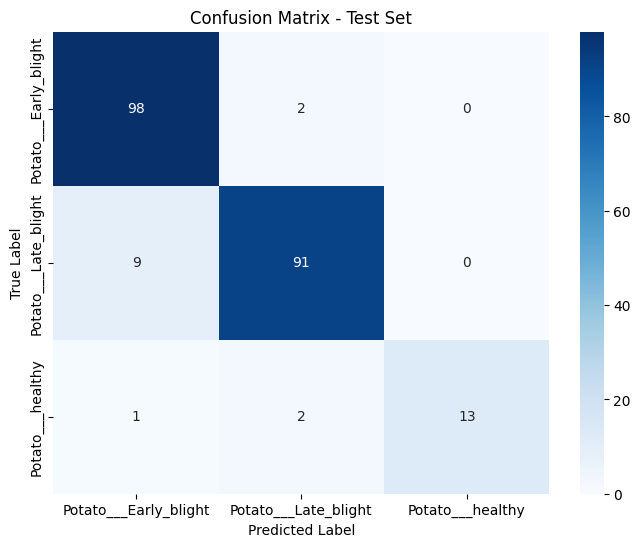


Classification Report - Test Set:

                       precision    recall  f1-score   support

Potato___Early_blight       0.91      0.98      0.94       100
 Potato___Late_blight       0.96      0.91      0.93       100
     Potato___healthy       1.00      0.81      0.90        16

             accuracy                           0.94       216
            macro avg       0.96      0.90      0.92       216
         weighted avg       0.94      0.94      0.93       216

Test Accuracy: 0.9352
F1 Score (Macro): 0.9241
F1 Score (Weighted): 0.9348


In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

model = load_model("best_finetune_model.keras")  # pastikan ini model hasil fine-tuning

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

report = classification_report(true_classes, pred_classes, target_names=class_labels)
print("\nClassification Report - Test Set:\n")
print(report)

test_acc = accuracy_score(true_classes, pred_classes)
f1_macro = f1_score(true_classes, pred_classes, average='macro')
f1_weighted = f1_score(true_classes, pred_classes, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")


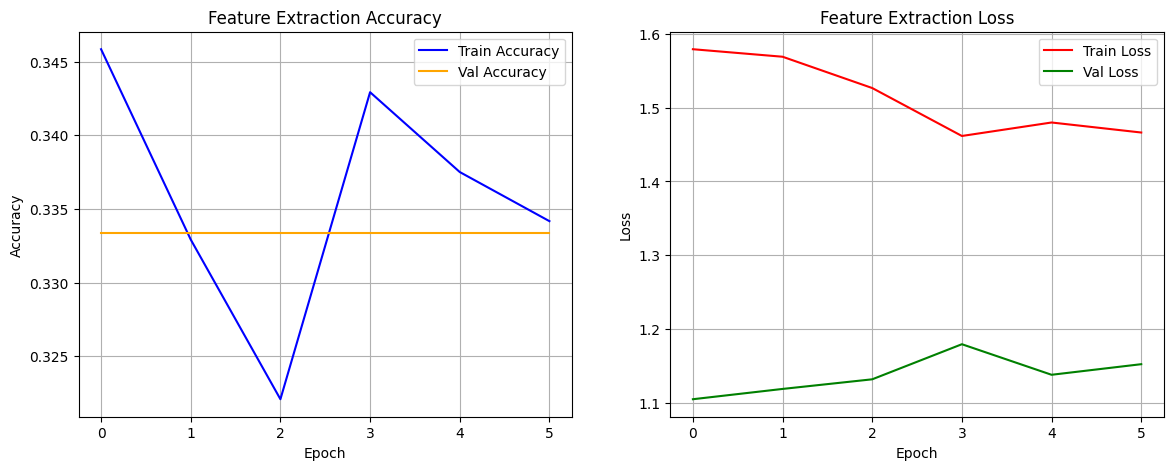

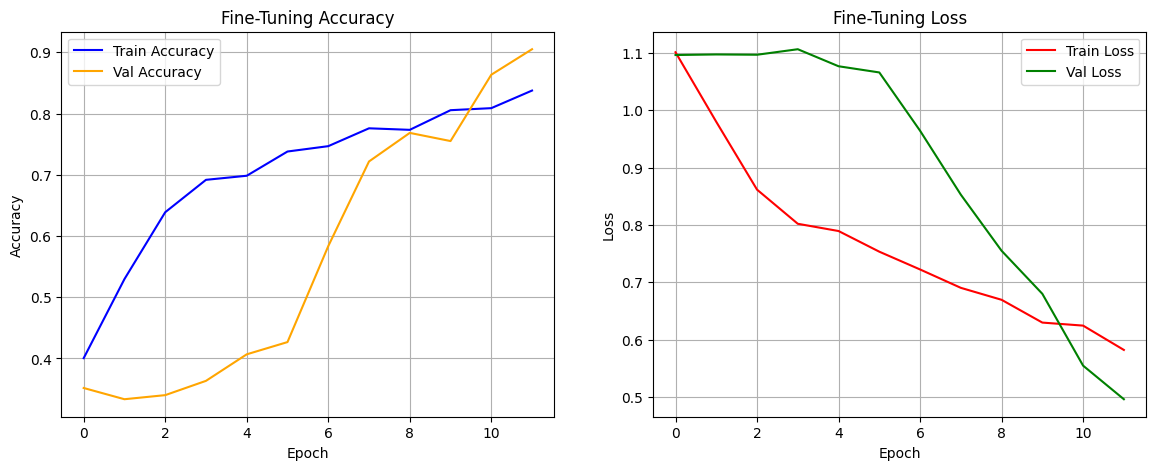

In [68]:
import matplotlib.pyplot as plt

def plot_history(hist, title_prefix="Training"):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy', color='orange')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss', color='red')
    plt.plot(hist.history['val_loss'], label='Val Loss', color='green')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history(history, "Feature Extraction")

plot_history(history_finetune, "Fine-Tuning")


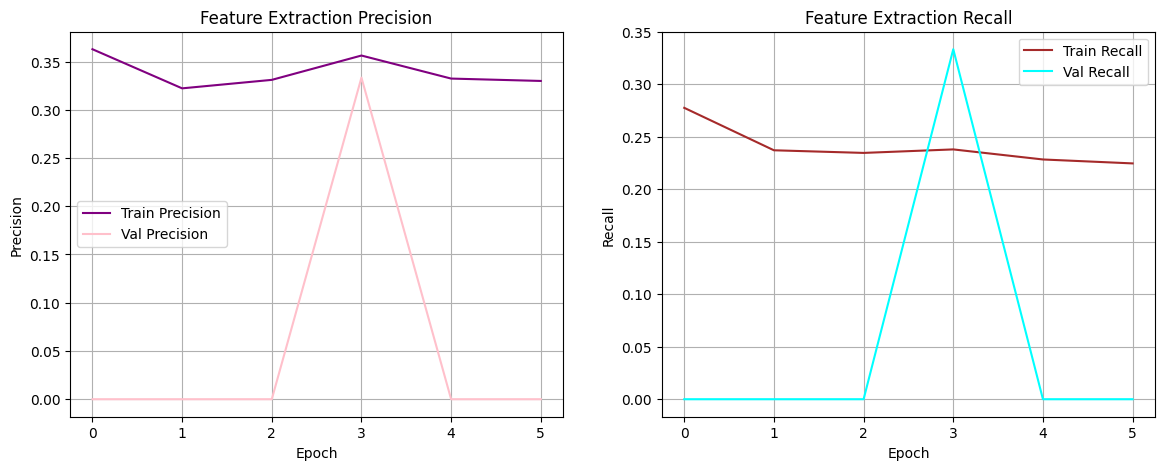

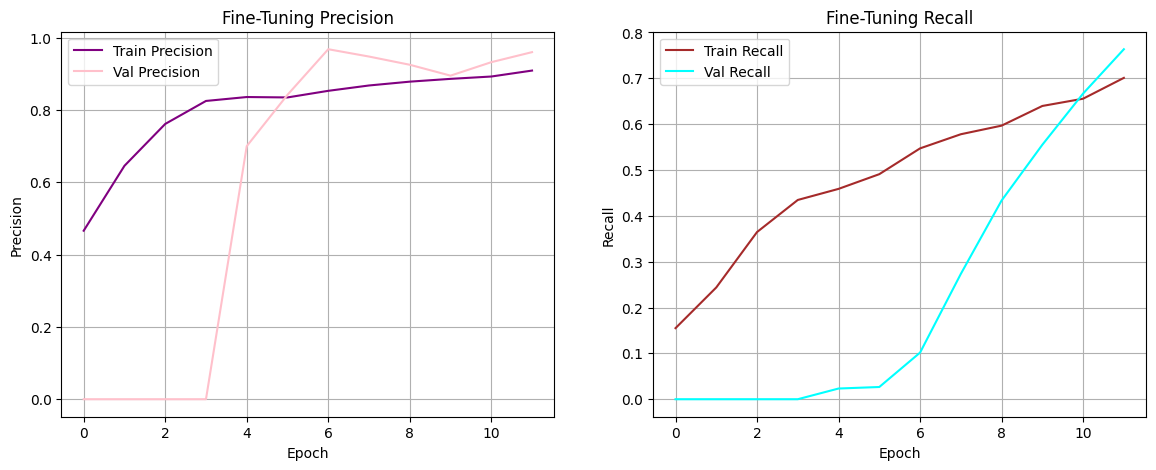

In [69]:
def plot_precision_recall(hist, title_prefix="Training"):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['precision'], label='Train Precision', color='purple')
    plt.plot(hist.history['val_precision'], label='Val Precision', color='pink')
    plt.title(f"{title_prefix} Precision")
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['recall'], label='Train Recall', color='brown')
    plt.plot(hist.history['val_recall'], label='Val Recall', color='cyan')
    plt.title(f"{title_prefix} Recall")
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_precision_recall(history, "Feature Extraction")
plot_precision_recall(history_finetune, "Fine-Tuning")


In [55]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
import re

def predict_uploaded_image(model, class_names):
    print("\nSilakan upload gambar daun kentang untuk diprediksi...")
    uploaded = files.upload()

    for filename, data in uploaded.items():
        img = Image.open(io.BytesIO(data)).convert('RGB')
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        predicted_class = class_names[np.argmax(pred)]
        confidence = np.max(pred) * 100

        predicted_class_clean = re.sub(r'_+', ' ', predicted_class).replace('Potato', '').strip()

        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{predicted_class_clean} ({confidence:.2f}%)", fontsize=12)
        plt.show()

        print(f"Hasil Prediksi: {predicted_class_clean}")
        print(f"Persentase Prediksi: {confidence:.2f}%\n")

        print("Probabilitas model terhadap setiap kelas:")
        for i, cls in enumerate(class_names):
            cls_clean = re.sub(r'_+', ' ', cls).replace('Potato', '').strip()
            print(f"  - {cls_clean:<15}: {pred[0][i]*100:.2f}%")

        if confidence >= 90:
            reason = f"Model sangat yakin bahwa citra ini termasuk kelas {predicted_class_clean}. Pola warna dan tekstur daun sangat sesuai dengan ciri khas kelas tersebut."
        elif 70 <= confidence < 90:
            reason = f"Model cukup yakin bahwa citra ini termasuk kelas {predicted_class_clean}, namun masih memiliki sedikit kemiripan dengan kelas lain."
        else:
            reason = f"Model kurang yakin. Citra ini memiliki kemiripan visual dengan beberapa kelas lain, sehingga prediksi {predicted_class_clean} bersifat perkiraan."

        print(f"\nPenjelasan Klasifikasi: {reason}\n")

class_names = list(val_generator.class_indices.keys())
predict_uploaded_image(model, class_names)



Silakan upload gambar daun kentang untuk diprediksi...


ini simpenan dulu

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

healthy_path = os.path.join(train_dir, "Potato___healthy")
target_images = 800

# Hapus augmentasi lama
for f in os.listdir(healthy_path):
    if f.startswith("aug_"):
        os.remove(os.path.join(healthy_path, f))

print("Augmentasi lama dihapus!")

# Ambil daftar file asli (bukan augmentasi)
original_files = [f for f in os.listdir(healthy_path) if not f.startswith("aug_")]
current_images = len(original_files)
print("Jumlah awal healthy:", current_images)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)

# Loop sampai target tercapai
i = 0
while current_images + i < target_images:
    # Pilih file secara acak supaya tidak monoton
    img_name = np.random.choice(original_files)
    img_path = os.path.join(healthy_path, img_name)
    img = load_img(img_path)
    x = np.expand_dims(img_to_array(img), axis=0)

    save_prefix = "aug_" + os.path.splitext(img_name)[0]

    # Hanya ambil 1 gambar per loop agar kontrol i tepat
    batch_iter = datagen.flow(
        x,
        batch_size=1,
        save_to_dir=healthy_path,
        save_prefix=save_prefix,
        save_format='jpg'
    )
    next(batch_iter)  # generate 1 gambar
    i += 1

print("Augmentasi selesai!")
print("Jumlah healthy sekarang:", len(os.listdir(healthy_path)))


Augmentasi Potato___Late_blight selesai! Total sekarang: 799
Augmentasi Potato___healthy selesai! Total sekarang: 777
Augmentasi Potato___Early_blight selesai! Total sekarang: 798


Found 2200 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Total training images: 2200
Total validation images: 430

Distribusi kelas:
{'Potato___Early_blight': 800, 'Potato___Late_blight': 700, 'Potato___healthy': 700}

Class weights:
{0: np.float64(1.0476190476190477), 1: np.float64(1.0476190476190477), 2: np.float64(0.9166666666666666)}


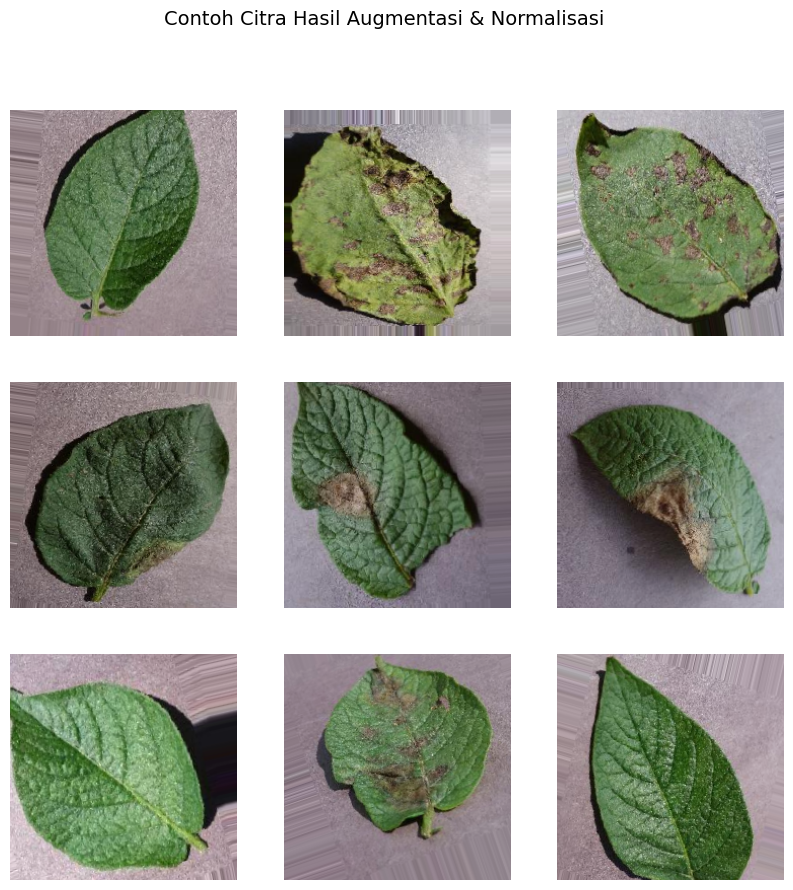

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Total training images: {train_generator.samples}")
print(f"Total validation images: {val_generator.samples}")

counts = pd.Series(train_generator.classes).value_counts()
labels = list(train_generator.class_indices.keys())
print("\nDistribusi kelas:")
print(dict(zip(labels, counts)))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:")
print(class_weights)

# Contoh citra hasil augmentasi
sample_images, _ = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle("Contoh Citra Hasil Augmentasi & Normalisasi", fontsize=14)
plt.show()

In [62]:
# Unfreeze sebagian layer
for layer in base_model.layers[-200:]:
    layer.trainable = True

# Re-compile model dengan learning rate
fine_tune_lr = 1e-5
model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callback untuk early stopping dan save model terbaik
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_finetune_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/12


KeyboardInterrupt: 

Found 216 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


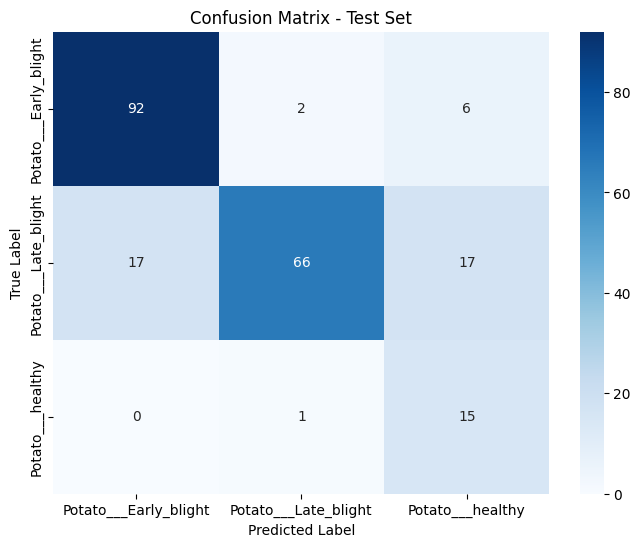


Classification Report - Test Set:

                       precision    recall  f1-score   support

Potato___Early_blight       0.84      0.92      0.88       100
 Potato___Late_blight       0.96      0.66      0.78       100
     Potato___healthy       0.39      0.94      0.56        16

             accuracy                           0.80       216
            macro avg       0.73      0.84      0.74       216
         weighted avg       0.86      0.80      0.81       216

Test Accuracy: 0.8009


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load model terbaik fine-tune
model = load_model("best_finetune_model.keras")

# Data generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Prediksi kelas di test set
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Classification Report
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print("\nClassification Report - Test Set:\n")
print(report)

# Accuracy
test_acc = accuracy_score(true_classes, pred_classes)
print(f"Test Accuracy: {test_acc:.4f}")
